# Tablut via Reinforcement Learning
---
The goal here is to construct an engine to play the historical Scandinavian game Tablut, using a tabula rasa Reinforcement Learning approach as developed by Alpha Zero. In this notebook I'll run through all of my code, starting with logic to play the game, then designing a model to provide move probabilities and positional assesment, then setting up a MCTS pipeline to the generate data to iteratively train the model.

__About Tablut:__\
Tablut as drawn by Linnaeus\
![Tablut Setup](/Users/peterbitman/Desktop/tafl/data/linnaeus-1.png)

__Challenges:__
- Lack of computing power overall
- Particularly important during self-play

## Initial Thoughts

__On Gameplay:__

The first challenge is to create an engine that can play the game under the exact rules. This engine should be reasonably efficient, as the gameplay element is the most expensive in the pipeline. It should also be relatively straighforward so that I can call the important methods (finding moves, applying moves, checking for terminal state) in a practical way during MCTS. In fact, it should __only deal with the basic mechanics__. Every other element (logging, tracking, tensor assembly, etc) should be handled by the class methods that will run the game during our training pipeline. This way, we will be able to reuse our logic for playing the game and expanding our search tree.

This challenge is fairly straightforward, and I have already done this for my first 1D implementation. However, because I am using a more complex model, and am attempting to leverage CNNs, and am trying to do this with a sophisticated enough approach to justify sinking some compute units into game simulation and training, I want to use a more structured approach to considering input format. This brings us to the second challenge - identifying a reasonable representation of Tablut for our model and then implementing the translation of our gamestate into this image. 

__On Input:__

The first element is straightforward and just comprises the information that we need to describe the position currently on the board. 4x 9x9 bitvectors does this for us, the first is set to 1 for WHITE else 0; the second encodes 1 for BLACK else 0; the third encodes 1 for the KING else 0; the fourth is less obvious, encoding the Castle square if it is empty with 1 else 0. However, this only gives us the game representation we were have if we had just walked up behind two players and glanced over the board - and unfortunately the state of this game (in a Markovian sense of 'state') is not accurately reflected only by piece positions. There are rules surrounding continuous repetitions. Unfortunately, these rules are murky and, worse, recently contested. 

__Unfortunate Foray into Repetition Rules in Tafl Games:__

The [Aage Nielsen](http://aagenielsen.dk/historical_hnefatafl_rules.php) rules state that repetitions are not allowed and result in a loss for White. 

In a [leaflet](http://tafl.cyningstan.com/data-download/1012/copenhagen-hnefatafl-leaflet) written by Damian Walker, the rule for _Copenhagen Hneftatl_ states:
<blockquote>
"Perpetual repetition is illegal. If the board position is repeated three times, the player in control of the situation must find another move."
</blockquote>

The [final post](http://aagenielsen.dk/hnefataflforum/phpBB3/viewtopic.php?f=1&t=112&start=10) in a spirited forum discussion about repetitions and vaguery in the Copenhagen rules ended:
<blockquote>
"October 2020 Adam Bartley started a discussion with Mario Aluizo ("casshern") and myself about repetitions in Tafl, and we came to the conclusion that the repetitions rule can be simplified, so that repetitions are always a loss for white (the defenders).

I searched the full archive ten years for games ending in black repetitions and found none.

Repetitions being always a loss for white has also earlier been suggested by Ytreza, Nath, OdinHimself and Unhandyandy.

So the repetitions rule will be:
Rule 8: Any perpetual repetition results in a loss for white."
</blockquote>

I am thankful for this clarification in the blog, as the wording *"the player in control of the situation"* gave me a shiver down my spine. So even though there is a lack of clarity here -what constitutes a *perpetual* repetition- I'll make my own interpretation for training which I think the forum mods would be incomfortable with, and copy chess's 3-fold repetition rule. Those guys knew what they were doing. 

I will follow the chess approach of 'counting' unique positons, most likely via Zobrist hashing to generate keys. Initially I thought to only track the last few moves and see if they were directly repetitive (two pieces moving back and forth across two squares), but this ignores the possibility of a multi-piece repetitive sequence. The issue with a chess-like approach is this could lead to losses for White in circumstances where the player could reasonably feel that she is 'sniffing out' an exit with long sequences of non-repetitive moves that circle back to the same positions. However, the piece mobility and space involved in the game, combined with the inherent asymmetry, makes me believe that the vast majority of repetition occurances would be short-sequence shuffles with the King or White, moving away from, or protecting against, capture by Black. In cases where White is 'in control of the situation', by which I read, 'is leading the repetitive sequence', they will hopefully avoid repetitive moves once the Neural Net learns the associated penalties. And the Monte Carlo Tree Search approach will penalize branches associated with these instances in any case.

Because the vast majority of repetitions will be quickfire, I will store the previous 7 board positions and pass these into the model. Doing this will have the oddity of needing Black to 'accept' the draw by making the last repeated move to win, when the move-1 by White is essentially an invitation for Black to end the game so should strictly be the last move. I don't see an elegant way around this while keeping the engine resilient to multi-sequence repetitions. AlphaZero and Lc0 both used past board positions in part to flag repetiitions, and it may well help the model recognise patterns during training as suggested by Klein in Neural Networks for Chess. This topic has been dfiscussed at length on the Lc0 message boards in more online community spirited debate. In principle, I understand the skeptic's angle that the game state should be Markovian, 8 states alone are not garuanteed to capture the details of repetition, and MCTS should deal entirely with the issues of reptition avoidance / encouragement. However, some of the arguments laid out in favour of history planes are convincing enough, and one of the Lc0 devs made clear that history inclusion definitively improved performance in some observed cases. Additionally, when dealing with such deep networks, additional input planes are very cheap, so any information that will help the Network learn should certainly be included. For example, out of curiosity I constructed my initial model (pending change) with both (8, 9, 9) and (57, 9, 9) input shapes, and the number of trainiable parameters only increased from 3,309,044 to 3,365,492. Fascinating!

__Returning to Input Format:__

As explained above, we describe our board with a 4x 9x9 tensor. To encode repetitions, we'll add 2 more planes as repitition counters - the first will be all 1s if the position has already appeared at least once, and the second will be all 1s if the position has already appeared twice. The 7th plane will mark the player's turn - full of Zeros for Black and Ones for White. This gives us a (7, 9, 9) shape, which we will stack the previous 7 moves onto for a total of (56, 9, 9). I am still not sure that including history is the best move - clearly in practice this had led to improved performance, but it introduces complications (introducing a hash system, etc) that I have never dealt with before. Maybe that alone is good enough reason to try. One last thought that I'd had was including a plane of Board Edges, as they are special squares for win conditions. However, I think that there is a chance that this would 'overweigh' these areas of the board, and the approach of dilineating important areas as constants hasn't been used elsewhere that I can see. One common approach that I am adopting is the inclusion of a constant plane of 1s in the input - this will help the network distinguish the boundaries of the board during convolutions. This results in a final input shape of (57, 9, 9) as broken down in the image below:

![](/Users/peterbitman/Desktop/tafl/muninn/tablut/tablut_tensor.jpg)

__Lc0 Message Board Debate on the Importance of History Planes:__

https://groups.google.com/g/lczero/c/ExytXAdPihE/m/pkcioE9HBQAJ
https://groups.google.com/g/lczero/c/7p7Q63xN56c/m/6dzqBOFcBgAJ
https://groups.google.com/g/lczero/c/KUwypuefNdY/m/Y3ERW1irCAAJ

## First Step: Basic Gameplay

This just ensures that I can create a board, and move  pieces around on it. We'll create a class for the Board, complete with sensible constants, and methods for basic game mechanics. Then I want to depart from my proof of concept structure and take advantage of a more fleshy 'play game' class that includes all of the legwork necessary for feeding into the MCTS / CNN pipeline. Eventually I will create other classes to handle gameplay between human agents and the model, and among models. 

In [59]:
## IMPORTS
import numpy as np
import time
import timeit
import random
import matplotlib.pyplot as plt
from copy import deepcopy

In [60]:
## FUNCTION TO GENERATE HASHABLE OUTPUT INDEX
def generate_output_index():
    """
    Creates an output index for all possible Tablut moves. Returns a dictionary: output_index['(0,0), (0,1)'] = 1
    """
    output_index = {}
    index_value = 0
    for i in range(9):
        for j in range(9):
            for k in range(9):
                if k != j:
                    output_index[f'({i}, {j}), ({i}, {k})'] = index_value
                    index_value += 1
                if k != i:
                    output_index[f'({i}, {j}), ({k}, {j})'] = index_value
                    index_value += 1
    return output_index

output_index = generate_output_index()
print(output_index)
print(f'{len(output_index)} unique moves')

{'(0, 0), (0, 1)': 0, '(0, 0), (1, 0)': 1, '(0, 0), (0, 2)': 2, '(0, 0), (2, 0)': 3, '(0, 0), (0, 3)': 4, '(0, 0), (3, 0)': 5, '(0, 0), (0, 4)': 6, '(0, 0), (4, 0)': 7, '(0, 0), (0, 5)': 8, '(0, 0), (5, 0)': 9, '(0, 0), (0, 6)': 10, '(0, 0), (6, 0)': 11, '(0, 0), (0, 7)': 12, '(0, 0), (7, 0)': 13, '(0, 0), (0, 8)': 14, '(0, 0), (8, 0)': 15, '(0, 1), (0, 0)': 16, '(0, 1), (1, 1)': 17, '(0, 1), (0, 2)': 18, '(0, 1), (2, 1)': 19, '(0, 1), (0, 3)': 20, '(0, 1), (3, 1)': 21, '(0, 1), (0, 4)': 22, '(0, 1), (4, 1)': 23, '(0, 1), (0, 5)': 24, '(0, 1), (5, 1)': 25, '(0, 1), (0, 6)': 26, '(0, 1), (6, 1)': 27, '(0, 1), (0, 7)': 28, '(0, 1), (7, 1)': 29, '(0, 1), (0, 8)': 30, '(0, 1), (8, 1)': 31, '(0, 2), (0, 0)': 32, '(0, 2), (0, 1)': 33, '(0, 2), (1, 2)': 34, '(0, 2), (2, 2)': 35, '(0, 2), (0, 3)': 36, '(0, 2), (3, 2)': 37, '(0, 2), (0, 4)': 38, '(0, 2), (4, 2)': 39, '(0, 2), (0, 5)': 40, '(0, 2), (5, 2)': 41, '(0, 2), (0, 6)': 42, '(0, 2), (6, 2)': 43, '(0, 2), (0, 7)': 44, '(0, 2), (7, 2)': 4

In [61]:
# FUNCTION TO DRAW BOARDSTATE AND TEST POSITIONS/TROUBLESHOOT
def draw_board(board_state):
    """
    Draw the game board using matplotlib based on the given board state.
    """
    board_state = np.array(board_state)
    board_state = np.reshape(board_state, (9, 9))
    fig, ax = plt.subplots()
    for i in range(1, 9):
        plt.axvline(x=i, color='black', linewidth=2)
    for j in range(1, 9):
        plt.axhline(y=j, color='black', linewidth=2)
    for i in range(9):
        for j in range(9):
            piece = board_state[j][i]  # Note: matplotlib uses (x, y) which is (col, row) in numpy
            if piece != 0:
                if piece == 2:
                    ax.text(i + 0.5, 8 - j + 0.5, 'B', color='black', ha='center', va='center', fontsize=20)
                elif piece == 1:
                    ax.text(i + 0.5, 8 - j + 0.5, 'W', color='red', ha='center', va='center', fontsize=20)
                elif piece == 4:
                    ax.text(i + 0.5, 8 - j + 0.5, 'C', color='green', ha='center', va='center', fontsize=20)
                else:
                    ax.text(i + 0.5, 8 - j + 0.5, 'K', color='orange', ha='center', va='center', fontsize=20)
    ax.set_aspect('equal')
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.axis('off')
    plt.show()

In [62]:
## FUNCTION TO CREATE SOME OF THE CONSTANT EDGE VARIABLES AT INITIALISATION
def generate_edges_set():
    """
    Returns a set of all the board edge squares.
    """
    edges = {(0, i) for i in range(9)} | {(8, i) for i in range(9)} | {(i, 0) for i in range(9)} | {(i, 8) for i in range(9)}
    return edges

In [391]:
## BOARD CLASS RESPONSIBLE FOR PERFORMING BASIC GAMEPLAY
class Board():
    """
    Board object that encodes all information about current position
    """
    # Basic piece constants
    EMPTY = 0
    WHITE = 1
    BLACK = 2
    KING = 3
    EMPTY_CASTLE = 4

    # Board specific constants
    CASTLE = (4, 4)
    CASTLE_SQUARES = {(3, 4), (4, 3), (4, 4), (4, 5), (5, 4)}

    EDGES = generate_edges_set()

    def __init__(self, zobrist):
        # keep track of turn, board state, and legal moves cache
        self.turn = self.WHITE
        self.board = np.zeros((9, 9), dtype=int)
        self.legal_moves = None
        # Tracker for King restrictions
        self.king_around_castle = False
        self.king_position = False
        # repetition counter will belong to the board, but its value be controlled by logic inside the game wrapper
        self.repetition_counter = 0
        self.no_legal_moves = False
        # Position Hashing class and board state hash value
        self.zobrist = zobrist
        self.zobrist_hash = 0

    def set_starting_position(self):
        """
        Sets board state to Tablut starting position, sets King castle location flag.
        """
        self.board = np.array([[self.EMPTY, self.EMPTY, self.EMPTY, self.BLACK, self.BLACK, self.BLACK, self.EMPTY, self.EMPTY, self.EMPTY],
                            [self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY, self.BLACK, self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY],
                            [self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY, self.WHITE, self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY],
                            [self.BLACK, self.EMPTY, self.EMPTY, self.EMPTY, self.WHITE, self.EMPTY, self.EMPTY, self.EMPTY, self.BLACK],
                            [self.BLACK, self.BLACK, self.WHITE, self.WHITE, self.KING, self.WHITE, self.WHITE, self.BLACK, self.BLACK],
                            [self.BLACK, self.EMPTY, self.EMPTY, self.EMPTY, self.WHITE, self.EMPTY, self.EMPTY, self.EMPTY, self.BLACK],
                            [self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY, self.WHITE, self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY],
                            [self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY, self.BLACK, self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY],
                            [self.EMPTY, self.EMPTY, self.EMPTY, self.BLACK, self.BLACK, self.BLACK, self.EMPTY, self.EMPTY, self.EMPTY]])

        # tuple (is King in/adjacent to castle?, location tuple)
        self.king_around_castle = True
        self.king_position = (4,4)
        self.zobrist_hash = self.zobrist.compute_hash(self.board)

    def find_captures(self, to_square):
        """
        Checks for any captures resulting from inputted move. Returns list of tuples (captured piece type, row, col).
        """
        # list to hold any captures found as result of move
        captures = []
        # turn dependent variables to simplify capture checks
        ally = {self.WHITE, self.KING, self.EMPTY_CASTLE} if self.turn == self.WHITE else {self.BLACK, self.EMPTY_CASTLE}
        enemy = self.WHITE if self.turn == self.BLACK else self.BLACK

        def add_captures(step):
            """
            Helper to find captures in given direction. Appends relevant captures to captures list.
            """
            enemy_index = (to_square[0] + step[0], to_square[1] + step[1])
            ally_index = (to_square[0] + 2 * step[0], to_square[1] + 2 * step[1])
            # check 'square two over' is on board
            if not (0 <= ally_index[0] < 9 and 0 <= ally_index[1] < 9):
                return
            # if square two over is 'allied' in terms of capturing rights, check middle square.
            if self.board[ally_index] in ally:
                adjacent_piece = self.board[enemy_index]
                if adjacent_piece == enemy:
                    captures.append((adjacent_piece, enemy_index[0], enemy_index[1]))
                # to handle King captures outside of the castle / castle borders
                if adjacent_piece == self.KING and self.turn == self.BLACK and not self.king_around_castle:
                    captures.append((adjacent_piece, enemy_index[0], enemy_index[1]))
                    self.king_position = None

        def add_king_captures(step):
            """
            Helper to find King captures with modified conditions in / adjacent to castle. Appends relevant capture to captures list.
            """
            non_attackers = {self.WHITE, self.EMPTY}
            king_index = (to_square[0] + step[0], to_square[1] + step[1])
            if king_index == self.king_position:
                # look at squares adjacent to King, if any of these are White or Empty then it returns
                for direction in [(-1, 0), (0, -1), (0, 1), (1, 0)]:
                    neighbor_index = (king_index[0] + direction[0], king_index[1] + direction[1])
                    if self.board[neighbor_index] in non_attackers:
                        return False
                # if function runs all the way through without returning, then the King is surrounded by capturing squares
                captures.append((self.KING, king_index[0], king_index[1]))
                self.king_position = None
                return True

        # iterate through adjacent squares, checking for captures
        for direction in [(-1, 0), (0, -1), (0, 1), (1, 0)]:
            add_captures(direction)

        if self.turn == self.BLACK and self.king_around_castle:
            for direction in [(-1, 0), (0, -1), (0, 1), (1, 0)]:
                if add_king_captures(direction):
                    break

        return captures

# TODO: implement ZH
    def apply_move(self, move):
        """
        Applies a move to the board. Takes a move as input and resets legal move 'cache'.
        """
        from_square = move[0]
        to_square = move[1]
        piece_moved = self.board[from_square]

        self.board[to_square] = piece_moved

        # sets departed square Empty for all non-king pieces
        if piece_moved != self.KING:
            self.board[from_square] = self.EMPTY
        else:
            # set King's previous square as either empty or empty castle depending on whether it moved from castle
            self.board[from_square] = self.EMPTY_CASTLE if self.king_position == self.CASTLE else self.EMPTY
            # update King location markers
            self.king_position = to_square
            self.king_around_castle = True if to_square in self.CASTLE_SQUARES else False

        # captures check
        captures = self.find_captures(to_square)
        for capture in captures:
            self.board[(capture[1], capture[2])] = self.EMPTY

        # switch to next player turn
        self.turn = self.BLACK if self.turn == self.WHITE else self.WHITE
        # reset legal move cache
        self.legal_moves = None

        # generate Zobrist for new boardstate
        self.zobrist_hash = self.zobrist.update_hash(hash_value=self.zobrist_hash, piece=piece_moved,
                                                         from_pos=from_square, to_pos=to_square, captures=captures)
        # query cache with new hash, update repetition count. Alternatively could do this in is_terminal and remove repetition counter. How do I include the node ids for MCTS though?
        # I think this should be done in the game wrapper. Almost tempted to remove all the zobrist hashing references.


    def generate_moves(self):
        """
        Collates and returns all legal moves for the given board state.
        """
        if self.legal_moves is None:
            moves = []

            for row in range(9):
                for col in range(9):
                    if self.board[row, col] == self.turn:
                        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            r, c = row + dr, col + dc
                            while 0 <= r < 9 and 0 <= c < 9:
                                target_square = self.board[r, c]
                                if target_square == self.WHITE or target_square == self.BLACK or target_square == self.KING:
                                    break
                                if target_square != self.EMPTY_CASTLE:
                                    moves.append(((row, col), (r, c)))
                                r += dr
                                c += dc
                    elif self.turn == self.WHITE and (row, col) == self.king_position:
                        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            r, c = row + dr, col + dc
                            while 0 <= r < 9 and 0 <= c < 9:
                                target_square = self.board[r, c]
                                if target_square == self.WHITE or target_square == self.BLACK:
                                    break
                                moves.append(((row, col), (r, c)))
                                r += dr
                                c += dc
            self.legal_moves = moves
            self.no_legal_moves = False if moves else True
        return self.legal_moves

    # TODO this is clearly not ideal - expensive process. Could implement some kind of speed-ups?
    def is_surround(self):
        """
        Determines if white pieces are surrounded to meet conditions for Black win.
        Returns True if surrounded, False otherwise.
        """
        # add searched coords to a set to reference
        searched_squares = set()

        def flood_fill(coords):
            """
            Recursive DFS flood fill function to determine if the white pieces are surrounded.
            True if flood fill finds a white piece / king, else false.
            """
            row, col = coords
            if 0 <= row < 9 and 0 <= col < 9 and (row, col) not in searched_squares:
                searched_squares.add((row, col))
                if self.board[row][col] == self.WHITE or self.board[row][col] == self.KING:
                    return True
                elif self.board[row][col] == self.EMPTY:
                    for dr, dc in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                        if flood_fill((row + dr, col + dc)):
                            return True
                return False

        # Check for surround condition from each edge square
        for edge in self.EDGES:
            if self.board[edge] == self.WHITE or self.board[edge] == self.KING:
                return False
            elif edge not in searched_squares and self.board[edge] != self.BLACK:
                if flood_fill(edge):
                    return False
        return True

    def is_terminal(self):
        """
        Detects terminal position, returns tuple (bool, int)
        """
        winner = None
        # white wins if King reaches edge or black has no moves
        if self.turn == self.BLACK: # terminal check occurs at beginning of each player's turn (each player can only win on the other's turn)
            if self.king_position in self.EDGES or self.no_legal_moves:
                winner = self.WHITE
                return True, winner
        # black wins by capture, or game repetition, or no moves, or surrounding.
        else:
            if self.king_position is None or self.repetition_counter == 3 or self.no_legal_moves or self.is_surround():
                winner = self.BLACK
                return True, winner

        return False, None

Great! We might need to tinker with this as we find bugs, but it has passed every basic case that I've set up manually, and the random games are finishing in a reasonable number of moves / with correct endgame positions. Let's continue onto the hashing problem.

white won in 49 moves!


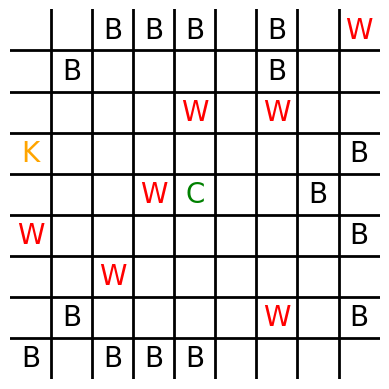

In [316]:
game_log = []
while b.is_terminal()[0] == False:
    move = random.choice(b.generate_moves())
    b.apply_move(move)
    game_log.append(deepcopy(b.board))

winner = 'white' if b.is_terminal()[1] == 1 else 'black'
print(f'{winner} won in {len(game_log)} moves!')

draw_board(game_log[-1])


## Zobrist Hashing
The first question is do I need to do this? I've already asked this above. Necessarily, no. But I want to avoid the issue of repetitions. However, does this mean that I will be generating thousands of keys for all the board states reached in a game? Assume a game takes 50 moves. Performing 100 iterations of MCTS every move, that means 5,000 dictionary entries. It's not ideal. But these will not all be stored at once. I'll iteratively create dictionaries for new MCTS searches, which means that only a max of 100 + moves played + 1. But they will all need to be hashed and queried x5000, and that's not nothing. 

It seems like the best way to hash boardstates for these types of games is [Zobrist Hashing](https://en.wikipedia.org/wiki/Zobrist_hashing#:~:text=Zobrist%20hashing%20is%20the%20first%20known%20instance%20of%20tabulation%20hashing,are%20either%20black%20or%20white.). With Zobrist Hashing, we should be able to incrementally update the hash with XOR operations, and avoid the expensive process of recalculating it from board position. I think that the main process of tracking the hash will be inside the Board object, so we will pass our ZobristHashing class in at Board instantiation. Also, we will adapt the apply_move method to update the stored hash value. To do this, we'll also need to know which pieces are captured so I can XOR out during the increment (this will require a quick refactor of what find_captures returns).

In [397]:
class ZobristHashing:
    def __init__(self):
        self.board_size = 9
        self.pieces = [1, 2, 3, 4]
        self.zobrist_table = {}       # Dictionary to store the random values for hashing
        self.init_zobrist_table()

    def init_zobrist_table(self):
        """Generate random 64-bit integers for each piece-position triple"""
        for piece in self.pieces:
            for row in range(self.board_size):
                for col in range(self.board_size):
                    self.zobrist_table[(piece, row, col)] = random.getrandbits(64)

    def compute_hash(self, board):
        """Returns hash from inputted board state"""
        hash_value = 0  # Initialize the hash value to 0
        for row in range(self.board_size):
            for col in range(self.board_size):
                piece = board[row][col]  # Get the piece at the current position
                if piece != 0:
                    # XOR the hash value with the Zobrist value for the piece at this position
                    hash_value ^= self.zobrist_table[(piece, row, col)]
        return hash_value  # Return the final hash value

    def update_hash(self, hash_value, piece, from_pos, to_pos, captures):
        """Returns incrementally updated hash value given old hash, piece moved, from square, to square, and list of captures (piece, row, col)"""
        # XOR the hash value with the Zobrist value for the piece's old position
        hash_value ^= self.zobrist_table[(piece, from_pos[0], from_pos[1])]
        # XOR in the Empty castle if necessary
        if from_pos == (4, 4):
            hash_value ^= self.zobrist_table[(4, 4, 4)]
        # XOR the hash value with the Zobrist value for the piece's new position
        hash_value ^= self.zobrist_table[(piece, to_pos[0], to_pos[1])]
        # XOR out the empty castle if need be
        if to_pos == (4, 4):
            hash_value ^= self.zobrist_table[(4, 4, 4)]
        # deal with captures if there are any - captures is list of [(piece, row, col)]
        if captures:
            for capture in captures:
                hash_value ^= self.zobrist_table[capture]

        return hash_value  # Return the updated hash value

0
11901834601111604604


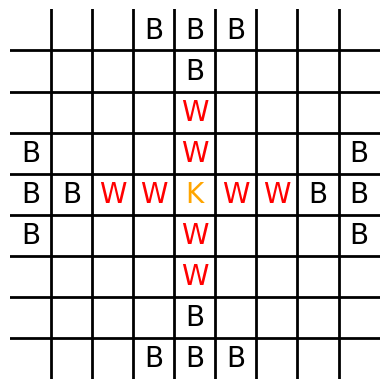

In [345]:
b = Board(zobrist=ZobristHashing())
print(b.zobrist_hash)
b.set_starting_position()
print(b.zobrist_hash)
draw_board(b.board)

11901834601111604604


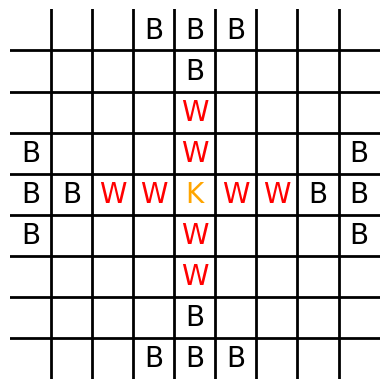

In [349]:
b.apply_move(((0,1), (0,3)))
print(b.zobrist_hash)
draw_board(b.board)

Now let's quickly test that, in a randomly simulated game, the updated hash is always equal to the computed hash.

In [500]:
zobrist = ZobristHashing()
b = Board(zobrist)
b.set_starting_position()
success = True
counter = 0
moves = []
boards = []
incremented_hashes = []
computed_hashes = []
while b.is_terminal()[0] == False:
    computed_hash = zobrist.compute_hash(b.board)
    computed_hashes.append(computed_hash)
    incremented_hash = b.zobrist_hash
    incremented_hashes.append(incremented_hash)
    if computed_hash != incremented_hash:
        print(f'hashes are not equal on move {counter}')
        success = False
        break
    move = random.choice(b.generate_moves())
    moves.append(move)
    b.apply_move(move)
    boards.append(deepcopy(b.board))
    counter += 1

if success:
    print(f"Same hashes for a game of {counter} moves.")

Same hashes for a game of 53 moves.


Nice! I've tested this >100 times now and, after some troubleshooting with the game/hashing mechanics, everything seems to work. We have the main building blocks of gameplay, but before we start putting everything together, let's start solidifying our model.

## Model Architecture
------
While my opposed to my proof of concept iteration was entirely fully connected,Dense layers, I want to experiment with using CNNs here. I'm trying to closely follow [Leela's model architecture](https://lczero.org/dev/backend/nn/#fn:3), using a core residual tower with successive Squeeze and Excitation Layers. I've attached a model diagram showing the topology in more detail. There are two ouputs, the 'Policy Head', which outputs a probability distribution mapped to all possible moves, and the 'Value Head', which outputs an assessment of the positional score. Because a tanh activation function is applied, this score will be between -1 and 1, the closer to 1 the more confident that this is a winning posiiton for the player whose turn it is. This is the first time that I've tried to construct a model of this complexity.

__A note on policy output:__

In my proof of concept model inspired by Klein's Hexapawn implementation, I used a flat distribution of all legal moves as my output. In that model, which was only comprised of fully connected layers, the tensor was then flattened and again fully connected to an output vector of the same size as the vector containing all possible moves. A softmax activation function was applied during the output layer. The index of the output vector corresponded to the index value of a valid move tuple, and the output value at every index represented the probability of the corresponding move being best. Of course, some moves are not legal in the input position, so these are masked out on return.

It seems that AlphaZero and Leela both looked at this approach, but went with a different direction. Moves were considered as possible moves from a square (piece independent). this is represented as 8 x 8 x 73 (8 x 8 for start squares on a chess board and 73 representing: 1. the 8 x 7 Queen moves of 'direction moved' x 'squares moved'; 2. the 8 Knight moves; 3. the 3 x 3 of 'pawn promotion move directions' x 'pawn underpromotions'. Initially, I wondered why they didn't encode this simply from every start square, with every possible legal move from that square, but the representation space ends up being significantly larger. In Leela, at least, the Policy Head convolves the tensor down in size to a tensor shape matching the 73x8x8 shape (actually 80x8x8 including zero-padding), and then flattens and maps the output vector to a flattened representation of the possible moves space (impossible moves are given the value of -1). The values of the legal moves in this moves space are themselves mapped to the indices of the flat legal moves vector containing moves recorded in a format that can be interpreted by the gameplay engine. I've included an example of what my output space looks like to help build an intuition here. AlphaZero mentioned in their paper that both approaches to output work, but that the multi-dimensional output space approach converges faster. It's my intuition that this approach avoids some potential information bottlenecks, and is a smoother transition for the model to learn from.

I had to spend a while researching the mapping process Leela uses, and the padding structure. The code for the mapping layer and a very helpful description can be found [here](https://github.com/LeelaChessZero/lc0/blob/master/src/neural/cuda/layers.cc). 

In [747]:
# CREATING POLICY OUTPUT MAP AND MOVE INDEX
def build_policy_map():
    # initialise space of the right size full of -1
    policy_map = np.full((32, 9, 9), -1)
    move_index = {}
    # to iterate and assign move indexes
    index = 0
    for row in range(9):
        for col in range(9):
            for left_moves in range(0, 8):
                if col > left_moves:
                    policy_map[(left_moves, row, col)] = index
                    move_index[index] = {((row, col), (row, col - left_moves - 1))}
                    index += 1

            for right_moves in range(0, 8):
                if col < 8 - right_moves:
                    policy_map[(8 + right_moves, row, col)] = index
                    move_index[index] = {((row, col), (row, col + right_moves + 1))}
                    index += 1

            for up_moves in range(0, 8):
                if row > up_moves:
                    policy_map[(16 + up_moves, row, col)] = index
                    move_index[index] = {((row, col), (row - up_moves - 1, col))}
                    index += 1

            for down_moves in range(0, 8):
                if row < 8 - down_moves:
                    policy_map[(24 + down_moves, row, col)] = index
                    move_index[index] = {((row, col), (row + down_moves + 1, col))}
                    index += 1

    return policy_map, move_index

policy_map, move_index = build_policy_map()

print(f'{policy_map.max()+1} legal moves indexed.')
print('-'*50)
print("Example of Plane 1 of 32 Representing all '1 Move Left' Moves. Note that all impossible moves (in this case, moving a piece on the leftmost column) are indexed -1.\n",'-'*50,'\n', policy_map[0])
policy_map = policy_map.flatten()
print('-'*50)
print(f"For example, the key '16' returns the move tuple ((from row, from col), (to row, to col)): {move_index[16]}.")

1296 legal moves indexed.
--------------------------------------------------
Example of Plane 1 of 32 Representing all '1 Move Left' Moves. Note that all impossible moves (in this case, moving a piece on the leftmost column) are indexed -1.
 -------------------------------------------------- 
 [[  -1   16   32   48   64   80   96  112  128]
 [  -1  160  176  192  208  224  240  256  272]
 [  -1  304  320  336  352  368  384  400  416]
 [  -1  448  464  480  496  512  528  544  560]
 [  -1  592  608  624  640  656  672  688  704]
 [  -1  736  752  768  784  800  816  832  848]
 [  -1  880  896  912  928  944  960  976  992]
 [  -1 1024 1040 1056 1072 1088 1104 1120 1136]
 [  -1 1168 1184 1200 1216 1232 1248 1264 1280]]
--------------------------------------------------
For example, the key '16' returns the move tuple ((from row, from col), (to row, to col)): {((0, 1), (0, 0))}.


In [ ]:
# MODEL THE MAPPING FROM 73x8x8 OUTPUT TENSOR TO PROBABILITY VECTOR
output_tensor = np.full((36,9,9))

In [516]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Layer, ReLU, Add, Dense, Flatten, Input, GlobalAveragePooling2D, Multiply, Reshape, Activation, BatchNormalization
from tensorflow.keras.models import Model

class SqueezeExcitation(Layer):
    def __init__(self, filters, se_channels, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.se_channels = se_channels
        self.global_avg_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(se_channels, activation='relu')
        self.dense2 = Dense(filters * 2)
        self.reshape = Reshape([1, 1, filters * 2])

    def call(self, inputs):
        x = self.global_avg_pool(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.reshape(x)
        scale, bias = tf.split(x, num_or_size_splits=2, axis=-1)
        scale = Activation('sigmoid')(scale)
        output = Multiply()([inputs, scale])
        output = Add()([output, bias])
        return output

def se_block(input_tensor, filters, se_channels):
    return SqueezeExcitation(filters, se_channels)(input_tensor)

def residual_block(x, filters, se_channels):
    shortcut = x
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = se_block(x, filters, se_channels)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def policy_head(x, policy_conv_size):
    policy = Conv2D(80, kernel_size=1, padding='same', use_bias=False)(x)
    policy = BatchNormalization()(policy)
    policy = ReLU()(policy)
    policy = Flatten()(policy)
    policy_output = Dense(1296, name='policy_head')(policy) # note there is no activation function on the output

    return policy_output

def value_head(x, value_conv_size):
    value = Conv2D(value_conv_size, kernel_size=1, padding='same', use_bias=False)(x)
    value = BatchNormalization()(value)
    value = ReLU()(value)
    value = Flatten()(value)
    value = Dense(128, activation='relu')(value)
    # note I am following AlphaZero/classical Leela approach here as there are no draws.
    value_output = Dense(1, activation='tanh', name='value_output')(value)

    return value_output

def build_tablut_model(input_shape, num_residual_blocks=10, filters=128, se_channels=32, policy_conv_size=32, value_conv_size = 32):
    inputs = Input(shape=input_shape)

    # Initial Input Convolutional Layer
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters, se_channels)

    policy_output = policy_head(x, policy_conv_size)

    value_output = value_head(x, value_conv_size)

    model = Model(inputs=inputs, outputs=[policy_output, value_output])

    return model

input_shape = (9, 9, 57)
model = build_tablut_model(input_shape)
model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 9, 9, 57)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_437 (Conv2D) │ (None, 9, 9, 128) │     65,664 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_437[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_433 (ReLU)    │ (None, 9, 9, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_438 (Conv2D) │ (None, 9, 9, 128) │    147,456 │ re_lu_433[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_438[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_434 (ReLU)    │ (None, 9, 9, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_439 (Conv2D) │ (None, 9, 9, 128) │    147,456 │ re_lu_434[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_439[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_excitation… │ (None, 9, 9, 128) │     12,576 │ batch_normalizat… │
│ (SqueezeExcitation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_572 (Add)       │ (None, 9, 9, 128) │          0 │ squeeze_excitati… │
│                     │                   │            │ re_lu_433[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_435 (ReLU)    │ (None, 9, 9, 128) │          0 │ add_572[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_440 (Conv2D) │ (None, 9, 9, 128) │    147,456 │ re_lu_435[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_440[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_436 (ReLU)    │ (None, 9, 9, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_441 (Conv2D) │ (None, 9, 9, 128) │    147,456 │ re_lu_436[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_441[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_excitation… │ (None, 9, 9, 128) │     12,576 │ batch_normalizat… │
│ (SqueezeExcitation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_575 (Add)       │ (None, 9, 9, 128) │          0 │ squeeze_excitati… │
│                     │                   │            │ re_lu_435[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_437 (ReLU)    │ (None, 9, 9, 128) │          0 │ add_575[0][0]   

 Total params: 6,852,305 (26.14 MB)

 Trainable params: 6,846,801 (26.12 MB)

 Non-trainable params: 5,504 (21.50 KB)

## Ideas:
Encoding repetitions: could have flag that shows that a loss by repetition is possible, and then mark the square that would lead to repetition. This would only add 2 extra squares, but overengineering the feature? Also not sure how this would apply to black. Takes away from the simplicity and 'zero' nature. Might as well start adding flags when a win is immediately available etc. (though this isnt a bad idea for endgame situations in competitive play!)

## Bibliography:

Alpha Zero Paper\
https://arxiv.org/pdf/1712.01815

Alpha Go Paper\
https://discovery.ucl.ac.uk/id/eprint/10045895/1/agz_unformatted_nature.pdf

Neural Networks for Chess\
https://arxiv.org/abs/2209.01506

Leela Chess Zero\
https://lczero.org/

-----------------

Squeeze and Excitation Networks\
https://arxiv.org/pdf/1709.01507

Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift\
https://arxiv.org/pdf/1502.03167

Group Normalization\
https://arxiv.org/pdf/1803.08494

Deep Residual Learning for Image Recognition\
https://arxiv.org/pdf/1512.03385

Convolution Arithmetic for Deep Learning\
https://arxiv.org/pdf/1603.07285v1

Visualising and Understanding CNNs\
https://arxiv.org/pdf/1311.2901

Fast Algorithms for Convolutional Neural Networks\
https://arxiv.org/pdf/1509.09308

Attention Is All You Need\
https://arxiv.org/pdf/1706.03762

--------------
Reinforcement Learning 10: Classic Games Case Study\
https://www.youtube.com/watch?v=ld28AU7DDB4&ab_channel=GoogleDeepMind

Monte Carlo Tree Search\
https://www.youtube.com/watch?v=UXW2yZndl7U&t=2s&ab_channel=JohnLevine

----------------

Why a Constant Plane of 1s in Input?\
https://ai.stackexchange.com/questions/11014/why-is-a-constant-plane-of-ones-added-into-the-input-features-of-alphago

-------------
A New Hashing Method with Application for Game Playing - Zobrist\
https://research.cs.wisc.edu/techreports/1970/TR88.pdf

Why are Initial Zobrist Elements Random?\
https://cs.stackexchange.com/questions/22033/why-is-the-initial-state-of-zobrist-hashing-random

-------------
Discussion around Leela Policy Head\
https://github.com/glinscott/leela-chess/issues/47

Lc0 Discord\
https://discord.com/channels/425419482568196106/427066771627966466/1088003369781698590

---------------
Temperature and Softmax\
https://stats.stackexchange.com/questions/527080/what-is-the-role-of-temperature-in-softmax